In [52]:
# Import libraries
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os, glob

## MODELS

In [53]:
model = gp.Model("model1")
x = model.addVar(name="x", vtype=GRB.CONTINUOUS)
y = model.addVar(name="y", vtype=GRB.CONTINUOUS)
z = model.addVar(name="z", vtype=GRB.CONTINUOUS)

model.addConstr(x + y + z <= 10, name="c1")

model.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

model.optimize()

for v in model.getVars():
    print(f"{v.varName}: {v.x}")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x0e99420c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+01]
Presolve removed 1 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.000000000e+01
x: 0.0
y: 0.0
z: 10.0


In [54]:
#Open jason file to load data
with open(r"instances\test1.json", "r") as file:
    data = json.load(file)


In [55]:
#print all attributes of the json file
for key, value in data.items():
    print(f"{key}: {value}")

Blocks: ['Block 001', 'Block 002', 'Block 003', 'Block 004', 'Block 005', 'Block 006']
Sessions: ['Session 001', 'Session 002', 'Session 003', 'Session 004', 'Session 005', 'Session 006', 'Session 007', 'Session 008']
Sessions_b: {'Block 001': ['Session 001', 'Session 002', 'Session 003'], 'Block 002': ['Session 004'], 'Block 003': ['Session 005'], 'Block 004': ['Session 006'], 'Block 005': ['Session 007'], 'Block 006': ['Session 008']}
Interpreters: ['Interpreter 001']
Languages: ['Dutch', 'English', 'French', 'German', 'Italian', 'Spanish']
Languages_s: {'Session 001': ['English', 'French', 'Spanish'], 'Session 002': ['English', 'Spanish'], 'Session 003': ['English', 'Spanish'], 'Session 004': ['English', 'Spanish'], 'Session 005': ['English', 'Spanish'], 'Session 006': ['English', 'Spanish'], 'Session 007': ['English', 'Spanish'], 'Session 008': ['English', 'Spanish']}
Languages_i: {'Interpreter 001': ['English', 'Spanish'], 'Interpreter 002': ['French', 'Spanish'], 'Interpreter 003

In [56]:
#Unpack data from json file
Blocks = data["Blocks"]
Sessions = data["Sessions"]
Sessions_blocks = data["Sessions_b"]
Interpreters = data["Interpreters"]
Languages = data["Languages"]
Languages_sessions = data["Languages_s"]
Languages_interpreters = data["Languages_i"]

In [57]:
print("Blocks:", Blocks)
print("sessions", Sessions)
print("Languages_sessions:", Languages_sessions)
print("Languages_interpreters:", Languages_interpreters)
print("Interpreters:", Interpreters)

Blocks: ['Block 001', 'Block 002', 'Block 003', 'Block 004', 'Block 005', 'Block 006']
sessions ['Session 001', 'Session 002', 'Session 003', 'Session 004', 'Session 005', 'Session 006', 'Session 007', 'Session 008']
Languages_sessions: {'Session 001': ['English', 'French', 'Spanish'], 'Session 002': ['English', 'Spanish'], 'Session 003': ['English', 'Spanish'], 'Session 004': ['English', 'Spanish'], 'Session 005': ['English', 'Spanish'], 'Session 006': ['English', 'Spanish'], 'Session 007': ['English', 'Spanish'], 'Session 008': ['English', 'Spanish']}
Languages_interpreters: {'Interpreter 001': ['English', 'Spanish'], 'Interpreter 002': ['French', 'Spanish'], 'Interpreter 003': ['Dutch', 'German'], 'Interpreter 004': ['Dutch', 'Spanish'], 'Interpreter 005': ['French', 'Italian', 'Spanish']}
Interpreters: ['Interpreter 001']


In [58]:
def Model_1(data, OBJ_FUNC=1):
    model = gp.Model("model1")
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]
    print("Pairwise languages sessions:", Pairwise_languages_sessions)

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints
    #Interpreter must speak the language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages_sessions[s]:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 1, 
                            name=f"interpreter_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
            
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(assign[b, s, l, i]
                                                            for l in Pairwise_languages_sessions[s]
                                                            for i in Interpreters) / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
                            
    

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                        for l in Pairwise_languages_sessions[s] for i in Interpreters), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]), GRB.MAXIMIZE)
    
    return model

In [59]:
model = Model_1(data)
model.optimize()
# Print the variable values
for v in model.getVars():
    print(f"{v.varName}: {v.x}")

Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26 rows, 18 columns and 40 nonzeros
Model fingerprint: 0x0bbcaeff
Variable types: 0 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presol

In [60]:
model = Model_1(data, 2)
model.optimize()
# Print the results
for v in model.getVars():
    if (v.x ==1):
        print(f"{v.varName}: {v.x}")
print(model.getVars())

Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26 rows, 18 columns and 40 nonzeros
Model fingerprint: 0x5ceca71b
Variable types: 0 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Preso

In [61]:
def Model_2(data, OBJ_FUNC=1):
    model = gp.Model("model2")
    
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]
    print("Pairwise languages sessions:", Pairwise_languages_sessions)

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints
    #Interpreter must speak the language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages_sessions[s]:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 1, 
                            name=f"interpreter_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
                
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(assign[b, s, l, i]
                                                            for l in Pairwise_languages_sessions[s]
                                                            for i in Interpreters) / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
            
    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                    for l in Pairwise_languages_sessions[s]) <= 15, 
                        name=f"max_hours_{i}")
    
    # Max 3 sessions in a row per interpreter
    for i in Interpreters:
        for j in range(len(Sessions_blocks) - 3):
                model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks[j:j+4] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 3, 
                                name=f"max_sessions_{b}_{s}_{i}")

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                        for l in Pairwise_languages_sessions[s] for i in Interpreters), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]), GRB.MAXIMIZE)
    
    return model

In [62]:
#Open jason file to load data
with open(r"instances\test1.json", "r") as file:
    data2 = json.load(file)
print(data2["Blocks"])
print(data2["Sessions"])
print(data2["Sessions_b"])

model_2 = Model_2(data2)
model_2.optimize()
# Print the results
for v in model_2.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")

['Block 001', 'Block 002', 'Block 003', 'Block 004', 'Block 005', 'Block 006']
['Session 001', 'Session 002', 'Session 003', 'Session 004', 'Session 005', 'Session 006', 'Session 007', 'Session 008']
{'Block 001': ['Session 001', 'Session 002', 'Session 003'], 'Block 002': ['Session 004'], 'Block 003': ['Session 005'], 'Block 004': ['Session 006'], 'Block 005': ['Session 007'], 'Block 006': ['Session 008']}
Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physi

In [63]:
list = [1, 2, 3 , 4, 5]
print(list[0:3])


[1, 2, 3]


In [64]:
def Model_3(data, OBJ_FUNC=1):
    #Bridge implementation
    model = gp.Model("model with bridge")
    
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]
    print("Pairwise languages sessions:", Pairwise_languages_sessions)

    #Pairwise_languages = Languages.copy()
    Pairwise_languages = [(l1, l2) for i, l1 in enumerate(Languages) 
                                          for l2 in Languages[i+1:]]
    print("Pairwise languages:", Pairwise_languages)

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages:
                for i in Interpreters:
                    assign[b, s, l, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{b}_{s}_{l}_{i}")

    #language pair covered
    cover_language_pair = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                cover_language_pair[b, s, l] = model.addVar(vtype=GRB.BINARY, name=f"cover_language_pair_{b}_{s}_{l}")
                
    #bridge variables
    bridge = {}
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i1 in Interpreters:
                    for i2 in Interpreters:
                        if i1 != i2:
                            for l_p in Languages_interpreters[i1]:
                                if (l_p in Languages_interpreters[i2] and l_p not in l):
                                    bridge[b, s, l, i1, i2, l_p] = model.addVar(vtype=GRB.BINARY, name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")

    session_covered = {}
    for s in Sessions:
        #session_covered[s] = 1 if session s is covered by at least one interpreter
        session_covered[s] = model.addVar(vtype=GRB.BINARY, name=f"session_covered_{s}")
    
    # Add constraints

    #bridge if they have one language in common
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                for i1 in Interpreters:
                    for i2 in Interpreters:
                        if i1 != i2:
                            if l[0] not in Languages_interpreters[i1] or not l[1] in Languages_interpreters[i2]:
                                for l_p in Languages_interpreters[i1]:
                                    if (l_p in Languages_interpreters[i2] and l_p not in l):
                                        model.addConstr(bridge[b, s, l, i1, i2, l_p] ==0, name=f"bridge_{b}_{s}_{l}_{i1}_{i2}")
                            #if they have one language in common
                            else:
                                for l_p in Languages_interpreters[i1]:
                                    if (l_p in Languages_interpreters[i2] and l_p not in l):
                                        if Languages.index(l_p) < Languages.index(l[0]):
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[0]), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[1]), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                        
                                        elif(Languages.index(l_p) < Languages.index(l[1])):
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[0], l_p), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l_p, l[1]), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                        else:
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[0], l_p), i1],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            model.addConstr(bridge[b, s, l, i1, i2, l_p] <= assign[b, s, (l[1], l_p), i2],
                                                            name=f"bridge_{b}_{s}_{l}_{i1}_{i2}_{l_p}")
                                            
                            # else:
                            #     #Until l1
                            #     l0_idx = Languages.index(l[0])
                            #     l1_idx = Languages.index(l[1])
                            #     model.addConstr(2 * bridge[b, s, l, i1, i2] <= gp.max_(
                            #                     (gp.max_(assign[b, s, (l_prime, l[0]), i1] + assign[b, s, (l_prime, l[1]), i2] for l_prime in Languages[: l0_idx])), # 0 -> l0_idx
                            #                     (gp.max_(assign[b, s, (l[0], l_prime), i1] + assign[b, s, (l_prime, l[1]), i2] for l_prime in Languages[l0_idx + 1 :l1_idx])), # l0_idx + 1 -> l1_idx
                            #                     (gp.max_(assign[b, s, (l[0], l_prime), i1] + assign[b, s, (l[1], l_prime), i2] for l_prime in Languages[l1_idx + 1:]))), name=f"bridge_constrains_{b}_{s}_{l}_{i1}_{i2}")
                                                
    #Interpreter only does one bridge                                
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
                for i1 in Interpreters:
                        model.addConstr(gp.quicksum(bridge[b, s, l, i1, i2, l_p] for i2 in Interpreters if i1 != i2 for l in Pairwise_languages_sessions[s] for l_p in Languages_interpreters[i1] if (l_p in Languages_interpreters[i2] and l_p not in l)) <= 1, 
                                        name=f"bridge_{b}_{s}_{i1}_{i2}")
    
    #Interpreter must speak the language          
    for b in Blocks:
        for s in Sessions_blocks[b]:
            #change by pairwise language
            for l in Pairwise_languages:
                l1, l2 = l
                for i in Interpreters:
                    if l1 not in Languages_interpreters[i] or l2 not in Languages_interpreters[i]:
                        model.addConstr(assign[b, s, l, i] == 0, name=f"lang_{b}_{s}_{l}_{i}")
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(gp.quicksum(assign[b, s, l, i] for s in Sessions_blocks[b] for l in Pairwise_languages) <= 1, 
                            name=f"interpreters_{b}_{i}")
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages:
                model.addConstr(gp.quicksum(assign[b, s, l, i] for i in Interpreters) <= 1, 
                                name=f"session_{s}_{l}")
                
    #Session covered if all languages are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            model.addConstr(session_covered[s] <= gp.quicksum(cover_language_pair[b, s, l]
                                                            for l in Pairwise_languages_sessions[s])
                                                            / len(Pairwise_languages_sessions[s]), 
                                                            name=f"session_covered_{s}")
            
    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks for s in Sessions_blocks[b] 
                                    for l in Pairwise_languages_sessions[s]) <= 15, 
                        name=f"max_hours_{i}")
    
    # Max 3 sessions in a row per interpreter
    for i in Interpreters:
        for j in range(len(Sessions_blocks) - 3):
                model.addConstr(gp.quicksum(assign[b, s, l, i] for b in Blocks[j:j+4] for s in Sessions_blocks[b] for l in Pairwise_languages_sessions[s]) <= 3, 
                                name=f"max_sessions_{Blocks[j]}_{s}_{i}")
                

    #language pair covered if at one interpreter is assigned to it or there is a bridge
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(cover_language_pair[b, s, l] <= (gp.quicksum(assign[b, s, l, i] for i in Interpreters)) + (gp.quicksum(bridge[b, s, l, i1, i2, l_p] for i1 in Interpreters for i2 in Interpreters if i1 != i2 for l_p in Languages_interpreters[i1] if (l_p in Languages_interpreters[i2] and l_p not in l))),  
                                name=f"cover_language_pair_{b}_{s}_{l}")

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(gp.quicksum(cover_language_pair[b, s, l]
                                      for b in Blocks for s in Sessions_blocks[b]       
                                        for l in Pairwise_languages_sessions[s]), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(gp.quicksum(session_covered[s] for b in Blocks for s in Sessions_blocks[b]) , GRB.MAXIMIZE)
    
    return model

In [65]:
list = [1, 2, 3 , 4, 5]
idx_1 = list.index(2)
idx_2 = list.index(4)
print(list[:idx_1])
print(list[idx_1 + 1:idx_2])
print(list[idx_2 + 1:])


[1]
[3]
[5]


In [66]:

Model = Model_3(data2, 2)
Model.optimize()
# Print the results
for v in Model.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")


Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Pairwise languages: [('Dutch', 'English'), ('Dutch', 'French'), ('Dutch', 'German'), ('Dutch', 'Italian'), ('Dutch', 'Spanish'), ('English', 'French'), ('English', 'German'), ('English', 'Italian'), ('English', 'Spanish'), ('French', 'German'), ('French', 'Italian'), ('French', 'Spanish'), ('German', 'Italian'), ('German', 'Spanish'), ('Italian', 'Spanish')]
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 t

In [67]:
#Test1
#Open jason file to load data
with open(r"instances\test1.json", "r") as file:
    data3 = json.load(file)
m1 = Model_2(data3, 1)
m2 = Model_2(data3, 2)
m3 = Model_3(data3, 1)
m4 = Model_3(data3, 2)
m1.optimize()
m2.optimize()
m3.optimize()
m4.optimize()

# Print the results for Model_1
print("model 1, OF1")
for v in m1.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")
# Print the results for Model_3
print("model 3, OF1")
for v in m3.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")
# Print the results for Model_2
print("model 2, OF2")
for v in m2.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")
print("model 3, OF2")
# Print the results for Model_4
for v in m4.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")


Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spanish')], 'Session 004': [('English', 'Spanish')], 'Session 005': [('English', 'Spanish')], 'Session 006': [('English', 'Spanish')], 'Session 007': [('English', 'Spanish')], 'Session 008': [('English', 'Spanish')]}
Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('English', 'Spanish')], 'Session 003': [('English', 'Spani

In [68]:
#test bridge
#Open jason file to load data
with open(r"instances\test2.json", "r") as file:
    data_bridge = json.load(file)

model = Model_3(data_bridge, 1)
model.optimize()
# Print the results for the bridge model
print("Bridge model, OF1")
for v in model.getVars():
    if (v.x == 1):
        print(f"{v.varName}: {v.x}")


Pairwise languages sessions: {'Session 001': [('French', 'Italian'), ('French', 'Spanish'), ('Italian', 'Spanish')], 'Session 002': [('Dutch', 'Spanish')], 'Session 003': [('Dutch', 'Spanish')]}
Pairwise languages: [('Dutch', 'French'), ('Dutch', 'Italian'), ('Dutch', 'Spanish'), ('French', 'Italian'), ('French', 'Spanish'), ('Italian', 'Spanish')]
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 95 rows, 70 columns and 223 nonzeros
Model fingerprint: 0xf3eb9dd0
Variable types: 0 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 95 rows and 70 columns
Presolve time: 0.

## PLOTS

In [ ]:
# ------------------------------------------------------------
# 0) Where are your JSON instances?
# ------------------------------------------------------------
INST_DIR = r"simplie_instances"
#INST_DIR = r"instances"
instance_files = sorted(glob.glob(os.path.join(INST_DIR, "*.json")))

# ------------------------------------------------------------
# 1) Map a model-name to the *function* that builds it
# ------------------------------------------------------------
model_builders = {
    "Basic"      : Model_1,     # def Model(...)
    "Operational": Model_2,   # def Model_2(...)
    "Bridging"   : Model_3,   # def Model_3(...)
}

# ------------------------------------------------------------
# 2) Solve everything and fill `records`
# ------------------------------------------------------------
records = []   # this is what the plotting cell will consume

for f in instance_files:
    with open(f) as fp:
        data = json.load(fp)
    inst = os.path.splitext(os.path.basename(f))[0]   # e.g. "isp-S40-I30"

    for mname, build in model_builders.items():
        # --- objective 1 ----------------------------------------------------
        m1 = build(data, OBJ_FUNC=1)
        m1.optimize()
        of1 = m1.objVal

        # --- objective 2 ----------------------------------------------------
        m2 = build(data, OBJ_FUNC=2)
        m2.optimize()
        of2 = m2.objVal

        # --- store ----------------------------------------------------------
        records.append({
            "instance": inst,
            "model"   : mname,
            "OF1"     : of1,
            "OF2"     : of2,
        })

print(f"Collected {len(records)} rows → ready for plotting")


Pairwise languages sessions: {'Session 001': [('English', 'French'), ('English', 'Spanish'), ('French', 'Spanish')], 'Session 002': [('German', 'Spanish')], 'Session 003': [('English', 'Spanish')]}
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 34 rows, 28 columns and 99 nonzeros
Model fingerprint: 0x2391d37b
Variable types: 0 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 34 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available p

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

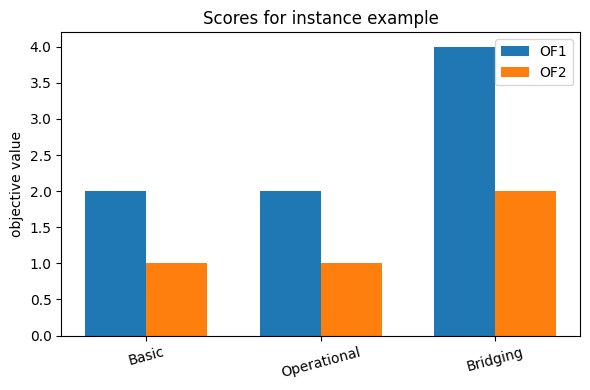

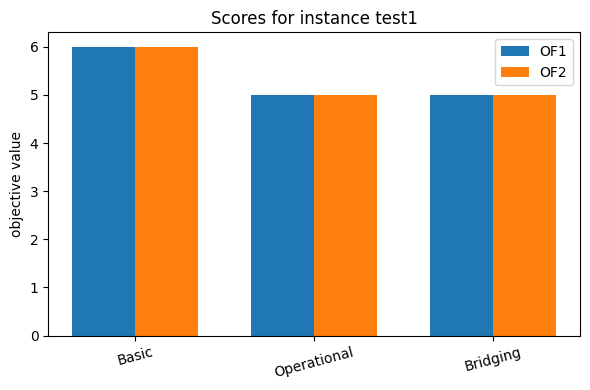

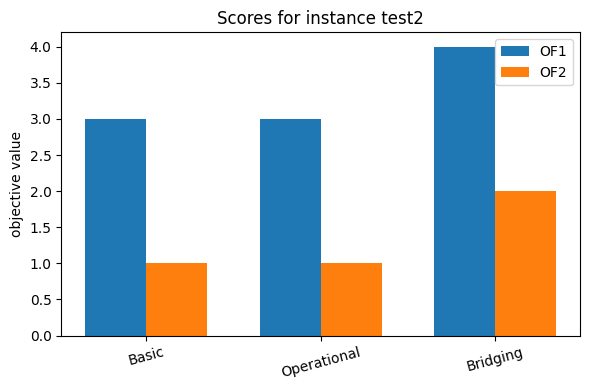

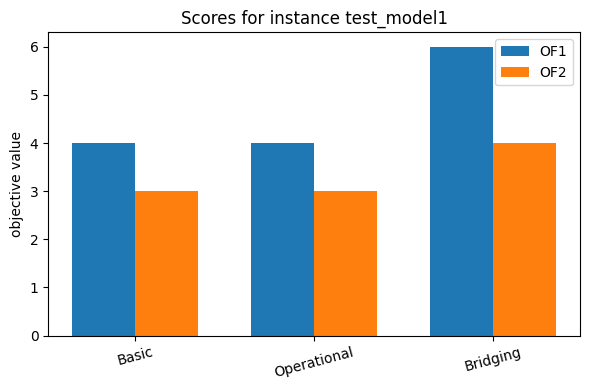

In [72]:
# ------------------------------------------------------------
# 1) Turn the raw list of dicts into a tidy DataFrame
# ------------------------------------------------------------
df = pd.DataFrame(records)              # ↳ or pd.read_json / pd.read_csv …
models_order = ["Basic", "Operational", "Bridging"]  # desired order on X-axis
df["model"] = pd.Categorical(df["model"], categories=models_order, ordered=True)

# ------------------------------------------------------------
# 2) One bar chart **per instance** ---------------------------------
# ------------------------------------------------------------
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # OF1 bars (left)
    bar2_x  = x_base + width/2          # OF2 bars (right)

    # heights for the bars
    of1_vals = sub.set_index("model")["OF1"].reindex(models_order)
    of2_vals = sub.set_index("model")["OF2"].reindex(models_order)

    ax.bar(bar1_x, of1_vals, width, label="OF1")
    ax.bar(bar2_x, of2_vals, width, label="OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"Scores for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("objective value")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"plots/{inst}.png", dpi=150, bbox_inches="tight")
    plt.show()
